# EfficientNet

## Installing & Importing Necessary Libraries

In [2]:
!pip install -q efficientnet_pytorch
!pip install -q wandb

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import torch
from sklearn.model_selection import train_test_split
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import wandb
wandb.login()
import os
import pandas as pd
import matplotlib.pyplot as plt

wandb: Currently logged in as: samyukta-palle (aipi549). Use `wandb login --relogin` to force relogin


In [ ]:
# Using W&B for better logging and visualizations
wandb.init(project="wound-classification-test", config={
    "learning_rate": 0.001,
    "architecture": "EfficientNet"
})

In [9]:
%cd /content/drive/MyDrive/

!unzip -q WoundDataset.zip -d /content/

/content/drive/MyDrive
replace /content/WoundDataset/test/Abrasions/mirrored_abrasions (78).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

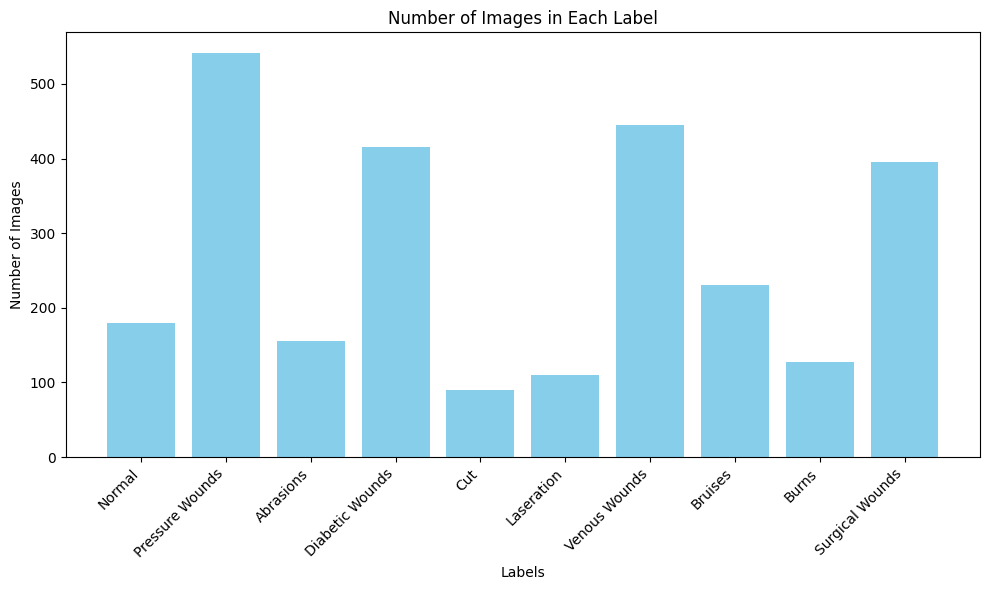

In [ ]:
# Path to your dataset directory
data_dir = '/content/WoundDataset/train'

# List all the images in the dataset directory
labels = os.listdir(data_dir)

# Initialize a dictionary to store the count of images in each label
label_count = {}

# Count the number of images in each label
for label in labels:
    label_path = os.path.join(data_dir, label)
    num_images = len(os.listdir(label_path))
    label_count[label] = num_images

# Create a bar graph to visualize the count of images in each label
plt.figure(figsize=(10, 6))
plt.bar(label_count.keys(), label_count.values(), color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Preprocessing

Data Transformations

In [ ]:
def preprocess(data_dir):
    """
    Preprocesses images in the specified directory.

    Args:
    - data_dir (str): Path to the dataset directory.

    Returns:
    - dataset (torchvision.datasets.ImageFolder): Preprocessed dataset.
    """
    # Define transformations to apply to the images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
        transforms.RandomVerticalFlip(),  # Randomly flip images vertically
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images
    ])

    # Create a dataset from the images in the specified directory
    dataset = datasets.ImageFolder(data_dir, transform=transform)

    return dataset

## Modelling

Train & Validate functions

In [ ]:
def train(model, device, trainloader, valloader, criterion, optimizer, epochs, model_path):
    """
    Train the model.

    Args:
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The device to run the training on (e.g., CPU or GPU).
    - trainloader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - valloader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
    - criterion: The loss function.
    - optimizer: The optimization algorithm.
    - epochs (int): Number of epochs to train the model.
    - model_path (str): Path to save the trained model.

    Returns:
    - total_loss (list): List of training losses per epoch.
    """
    best_loss = float('inf')
    total_loss = []

    # Loop through epochs
    for epoch in range(epochs):
        print(f'Epoch [{epoch+1}/{epochs}]')
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        progress_bar = tqdm(trainloader, desc=f'Epoch {epoch}/{epochs}', unit='batch')

        # Loop through batches in the training data
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            progress_bar.set_postfix(loss=running_loss / len(progress_bar), accuracy=100 * correct / total)

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct / total

        # Validation
        val_loss, val_accuracy = validate(model, device, valloader, criterion)

        total_loss.append(train_loss)
        print(val_accuracy)
        # Log metrics to W&B
        wandb.log({"epoch": epoch+1, "train_loss": train_loss, "train_accuracy": train_accuracy,
                   "val_loss": val_loss, "val_accuracy": val_accuracy})

        # Save the model if the validation loss is the best so far
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), model_path)
            print("Saving the model")

    print('Training finished!')
    return total_loss

def validate(model, device, valloader, criterion):
    """
    Validate the model.

    Args:
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The device to run the validation on (e.g., CPU or GPU).
    - valloader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
    - criterion: The loss function.

    Returns:
    - val_loss (float): Validation loss.
    - val_accuracy (float): Validation accuracy.
    """
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(valloader, desc='Validation', unit='batch')

    with torch.no_grad():
        # Loop through batches in the validation data
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_loss = criterion(outputs, labels)
            val_loss += batch_loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            progress_bar.set_postfix(loss=val_loss / len(progress_bar), accuracy=100 * correct / total)

    val_loss /= len(valloader)
    val_accuracy = 100 * correct / total

    return val_loss, val_accuracy


In [18]:
import time

# Record the starting time
start_time = time.time()

# Determine the device to use (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Path to the dataset directory
data_dir = '/content/WoundDataset/train'

# Preprocess the dataset
dataset = preprocess(data_dir)

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Number of epochs for training
epochs = 15

# Print the unique labels in the dataset
print(set(dataset.targets))

# Loop through folds for cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(dataset.imgs, dataset.targets)):
    print(f'Fold [{fold + 1}/5]')

    # Create train and validation datasets based on fold indices
    train_dataset = torch.utils.data.Subset(dataset, train_index)
    val_dataset = torch.utils.data.Subset(dataset, val_index)

    # Create DataLoader for train and validation datasets
    trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    # Initialize the model (EfficientNet-B0) with the appropriate number of output classes
    model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10)

    # Move the model to the selected device
    model = model.to(device)

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Initialize Weights & Biases for logging
    wandb.init(project="wound-classification", name=f"fold_{fold}")

    # Define the path to save the trained model
    model_path = f'/content/drive/MyDrive/saved_model_fold_{fold}.pth'

    # Train the model for the current fold
    train(model, device, trainloader, valloader, criterion, optimizer, epochs, model_path)

# Record the ending time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Total time taken: {elapsed_time} seconds")

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Fold [1/5]


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 323MB/s]


Loaded pretrained weights for efficientnet-b0


Epoch [1/15]


Validation: 100%|██████████| 17/17 [00:07<00:00,  2.32batch/s, accuracy=60.7, loss=1.92]


60.667903525046384
Saving the model
Epoch [2/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.28batch/s, accuracy=80.7, loss=0.752]


80.70500927643785
Saving the model
Epoch [3/15]


Validation: 100%|██████████| 17/17 [00:06<00:00,  2.74batch/s, accuracy=80.5, loss=0.685]


80.51948051948052
Saving the model
Epoch [4/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.71batch/s, accuracy=79.8, loss=0.79]


79.77736549165121
Epoch [5/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.77batch/s, accuracy=83.7, loss=0.688]


83.6734693877551
Epoch [6/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.87batch/s, accuracy=84.8, loss=0.563]


84.78664192949907
Saving the model
Epoch [7/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.14batch/s, accuracy=88.3, loss=0.449]


88.31168831168831
Saving the model
Epoch [8/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.71batch/s, accuracy=89.1, loss=0.412]


89.05380333951763
Saving the model
Epoch [9/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.75batch/s, accuracy=90.5, loss=0.447]


90.53803339517626
Epoch [10/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.36batch/s, accuracy=89.1, loss=0.397]


89.05380333951763
Saving the model
Epoch [11/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.36batch/s, accuracy=90.7, loss=0.341]


90.72356215213358
Saving the model
Epoch [12/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.82batch/s, accuracy=92.2, loss=0.297]


92.20779220779221
Saving the model
Epoch [13/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.63batch/s, accuracy=84.8, loss=0.676]


84.78664192949907
Epoch [14/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.33batch/s, accuracy=92.4, loss=0.313]


92.39332096474953
Epoch [15/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.77batch/s, accuracy=91.5, loss=0.359]

91.4656771799629
Training finished!
Fold [2/5]
Loaded pretrained weights for efficientnet-b0


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▇▇▇▇▇█▇█████
train_loss,█▄▃▂▂▂▂▂▁▂▁▁▁▁▁
val_accuracy,▁▅▅▅▆▆▇▇█▇██▆██
val_loss,█▃▃▃▃▂▂▁▂▁▁▁▃▁▁
epoch,15
train_accuracy,97.53717
train_loss,0.08241
val_accuracy,91.46568
val_loss,0.35933


Epoch [1/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.99batch/s, accuracy=60.8, loss=1.79]


60.78066914498141
Saving the model
Epoch [2/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.54batch/s, accuracy=72.5, loss=1.1]


72.4907063197026
Saving the model
Epoch [3/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.52batch/s, accuracy=81.2, loss=0.691]


81.22676579925651
Saving the model
Epoch [4/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.98batch/s, accuracy=78.1, loss=0.803]


78.06691449814126
Epoch [5/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.47batch/s, accuracy=76.4, loss=1.2]


76.39405204460967
Epoch [6/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.51batch/s, accuracy=80.3, loss=0.928]


80.29739776951673
Epoch [7/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.97batch/s, accuracy=84.6, loss=0.551]


84.5724907063197
Saving the model
Epoch [8/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.34batch/s, accuracy=87.7, loss=0.582]


87.73234200743494
Epoch [9/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.60batch/s, accuracy=93.1, loss=0.404]


93.12267657992565
Saving the model
Epoch [10/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.33batch/s, accuracy=92, loss=0.333]


92.00743494423791
Saving the model
Epoch [11/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.07batch/s, accuracy=90.5, loss=0.439]


90.52044609665427
Epoch [12/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.58batch/s, accuracy=91.6, loss=0.338]


91.635687732342
Epoch [13/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.61batch/s, accuracy=91.3, loss=0.468]


91.2639405204461
Epoch [14/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.12batch/s, accuracy=84, loss=0.662]


84.01486988847584
Epoch [15/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.55batch/s, accuracy=91.8, loss=0.449]

91.82156133828997
Training finished!
Fold [3/5]
Loaded pretrained weights for efficientnet-b0


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▇▇▇▇█▇██████
train_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▄▅▆▇██▇██▆█
val_loss,█▅▃▃▅▄▂▂▁▁▂▁▂▃▂
epoch,15
train_accuracy,96.74872
train_loss,0.12212
val_accuracy,91.82156
val_loss,0.44925


Epoch [1/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.81batch/s, accuracy=68.8, loss=1.13]


68.77323420074349
Saving the model
Epoch [2/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.27batch/s, accuracy=69.7, loss=1.32]


69.70260223048327
Epoch [3/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.44batch/s, accuracy=80.1, loss=0.807]


80.11152416356877
Saving the model
Epoch [4/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.88batch/s, accuracy=85.3, loss=0.511]


85.31598513011153
Saving the model
Epoch [5/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.75batch/s, accuracy=90.3, loss=0.312]


90.33457249070632
Saving the model
Epoch [6/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.20batch/s, accuracy=87.7, loss=0.383]


87.73234200743494
Epoch [7/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.73batch/s, accuracy=87.2, loss=0.442]


87.17472118959108
Epoch [8/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.69batch/s, accuracy=82.9, loss=0.735]


82.8996282527881
Epoch [9/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.30batch/s, accuracy=85.7, loss=0.474]


85.68773234200744
Epoch [10/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.40batch/s, accuracy=89.8, loss=0.373]


89.77695167286245
Epoch [11/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.74batch/s, accuracy=92.8, loss=0.31]


92.75092936802974
Saving the model
Epoch [12/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.78batch/s, accuracy=91.6, loss=0.383]


91.635687732342
Epoch [13/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.18batch/s, accuracy=87, loss=0.517]


86.98884758364312
Epoch [14/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.73batch/s, accuracy=90.9, loss=0.382]


90.89219330855019
Epoch [15/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.68batch/s, accuracy=92.6, loss=0.329]

92.56505576208178
Training finished!
Fold [4/5]
Loaded pretrained weights for efficientnet-b0


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▆▇█▇▇▇███▇██
train_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▄▆▇▇▆▅▆▇██▆▇█
val_loss,▇█▄▂▁▂▂▄▂▁▁▂▂▂▁
epoch,15
train_accuracy,96.00557
train_loss,0.12817
val_accuracy,92.56506
val_loss,0.32904


Epoch [1/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.00batch/s, accuracy=71.6, loss=0.986]


71.56133828996282
Saving the model
Epoch [2/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.27batch/s, accuracy=79.4, loss=0.713]


79.36802973977696
Saving the model
Epoch [3/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.64batch/s, accuracy=82.7, loss=0.563]


82.71375464684014
Saving the model
Epoch [4/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.68batch/s, accuracy=84.9, loss=0.477]


84.94423791821562
Saving the model
Epoch [5/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.16batch/s, accuracy=91.1, loss=0.286]


91.07806691449814
Saving the model
Epoch [6/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.65batch/s, accuracy=86.4, loss=0.423]


86.43122676579925
Epoch [7/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.69batch/s, accuracy=91.6, loss=0.304]


91.635687732342
Epoch [8/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.31batch/s, accuracy=88.5, loss=0.357]


88.47583643122677
Epoch [9/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.23batch/s, accuracy=90.3, loss=0.38]


90.33457249070632
Epoch [10/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.67batch/s, accuracy=94.8, loss=0.238]


94.79553903345725
Saving the model
Epoch [11/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.66batch/s, accuracy=91.8, loss=0.244]


91.82156133828997
Epoch [12/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.12batch/s, accuracy=91.1, loss=0.403]


91.07806691449814
Epoch [13/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.68batch/s, accuracy=92.9, loss=0.261]


92.93680297397769
Epoch [14/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.67batch/s, accuracy=89, loss=0.638]


89.03345724907064
Epoch [15/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.17batch/s, accuracy=93.9, loss=0.232]


93.86617100371747
Saving the model
Training finished!
Fold [5/5]
Loaded pretrained weights for efficientnet-b0


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▅▆▇▇▇▇▇▇██████
train_loss,█▄▃▂▂▂▂▂▂▁▁▂▁▁▁
val_accuracy,▁▃▄▅▇▅▇▆▇█▇▇▇▆█
val_loss,█▅▄▃▂▃▂▂▂▁▁▃▁▅▁
epoch,15
train_accuracy,96.23781
train_loss,0.12877
val_accuracy,93.86617
val_loss,0.23188


Epoch [1/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.99batch/s, accuracy=69.9, loss=1.14]


69.88847583643123
Saving the model
Epoch [2/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.43batch/s, accuracy=76.6, loss=0.852]


76.57992565055763
Saving the model
Epoch [3/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.37batch/s, accuracy=80.7, loss=0.735]


80.66914498141264
Saving the model
Epoch [4/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.94batch/s, accuracy=80.1, loss=0.738]


80.11152416356877
Epoch [5/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.34batch/s, accuracy=84.2, loss=0.577]


84.20074349442379
Saving the model
Epoch [6/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.40batch/s, accuracy=83.8, loss=0.775]


83.82899628252788
Epoch [7/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.98batch/s, accuracy=90.1, loss=0.376]


90.14869888475836
Saving the model
Epoch [8/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.98batch/s, accuracy=89.2, loss=0.483]


89.21933085501858
Epoch [9/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.46batch/s, accuracy=93.7, loss=0.264]


93.68029739776952
Saving the model
Epoch [10/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.34batch/s, accuracy=90.3, loss=0.366]


90.33457249070632
Epoch [11/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.97batch/s, accuracy=87, loss=0.605]


86.98884758364312
Epoch [12/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.45batch/s, accuracy=90.9, loss=0.38]


90.89219330855019
Epoch [13/15]


Validation: 100%|██████████| 17/17 [00:04<00:00,  3.41batch/s, accuracy=91.8, loss=0.381]


91.82156133828997
Epoch [14/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  2.92batch/s, accuracy=90.9, loss=0.42]


90.89219330855019
Epoch [15/15]


Validation: 100%|██████████| 17/17 [00:05<00:00,  3.20batch/s, accuracy=94.4, loss=0.34]

94.42379182156134
Training finished!
Total time taken: 2721.803253889084 seconds


## Plots

Train & Validation Accuracy; Train & Validation Loss is in W&B graphs

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# Determine the device to use (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the best model
best_model_path = '/content/drive/MyDrive/saved_model_fold_4.pth'
best_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10)
best_model.load_state_dict(torch.load(best_model_path))
best_model = best_model.to(device)
best_model.eval()

# Define the transformations for inference
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dir = '/content/WoundDataset/test'
# Preprocess the dataset
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Create DataLoader for the entire dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Evaluate the model on the test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

Loaded pretrained weights for efficientnet-b0


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming test_pred_y and y_test are your predicted and actual labels respectively

# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute precision
precision = precision_score(true_labels, predicted_labels, average='weighted')

# Compute recall
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Compute F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9400749063670412
Precision: 0.9459554624081109
Recall: 0.9400749063670412
F1 Score: 0.940831333329207


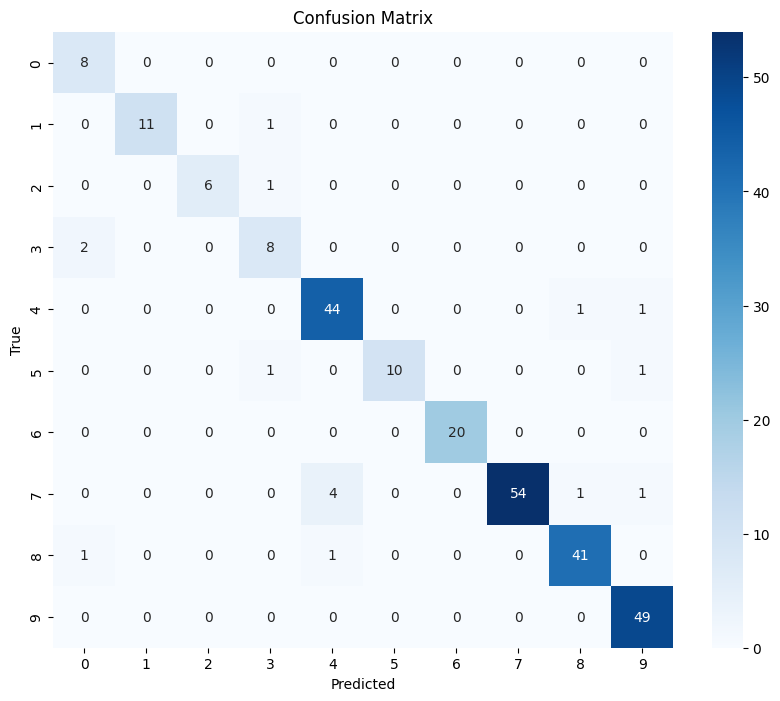

In [7]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Define your class labels
class_labels = ["Class 0", "Class 1", "Class 2", ...]  # Add your class labels here

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()